# CSC_52087_EP lab4a by Vicky Kalogeiton
# Ecole Polytechnique
# Multimodal Generative AI: CLIP + VQGAN Notebook

In [1]:
!git clone https://github.com/openai/CLIP.git
#https://github.com/openai/CLIP
#CLIP (Contrastive Language-Image Pre-Training)
#Learning Transferable Visual Models From Natural Language Supervision
#Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh,
#Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, Ilya Sutskever

!git clone https://github.com/CompVis/taming-transformers
#https://github.com/CompVis/taming-transformers
#Taming Transformers for High-Resolution Image Synthesis
#Patrick Esser, Robin Rombach, Björn Ommer




Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Total 256 (delta 0), reused 0 (delta 0), pack-reused 256 (from 1)
Receiving objects: 100% (256/256), 8.93 MiB | 9.39 MiB/s, done.
Resolving deltas: 100% (133/133), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1342 (delta 0), reused 0 (delta 0), pack-reused 1341 (from 2)
Receiving objects: 100% (1342/1342), 409.77 MiB | 14.17 MiB/s, done.
Resolving deltas: 100% (282/282), done.


In [2]:
## install some extra libraries
!pip install --no-deps ftfy regex tqdm
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [3]:
# import libraries
import numpy as np
import torch, os, imageio, pdb, math
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import yaml
from omegaconf import OmegaConf

from CLIP import clip

#import warnings
#warnings.filterwarnings('ignore')


## Helper functions

In [4]:
def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0))

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def norm_data(data):
  return (data.clip(-1,1)+1)/2 ### range between 0 and 1 in the result

### Parameters
learning_rate = .5
batch_size = 1
wd = .1 # weight decay
noise_factor = .22

total_iter=400 # total iterations --> try more 400
im_shape = [225, 400, 3] # height, width, channel (small for learning to increase speed; try more if you want e.g. 450x450!)
size1, size2, channels = im_shape




## CLIP

In [5]:
clipmodel, _ = clip.load('ViT-B/32', jit=False)
clipmodel.eval() # we do not want to train CLIP, we only want to use it at inference time
print(clip.available_models())

print("Clip model visual input resolution: ", clipmodel.visual.input_resolution)

device=torch.device("cuda:0")
torch.cuda.empty_cache() # empty the GPU memory

100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 34.8MiB/s]


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
Clip model visual input resolution:  224


In [ ]:
## above we see the models that CLIP can work with
## We also see the resolution of the images that CLIP takes as input

## VQ GAN

#### Taming transformer instantiation

In [6]:
%cd taming-transformers/

#### Download the VQ GAN pre-trained on ImageNet
#### f16 is the dimensionality of the codebook
!mkdir -p models/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p models/vqgan_imagenet_f16_16384/configs

if len(os.listdir('models/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
   !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt'
   !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'models/vqgan_imagenet_f16_16384/configs/model.yaml'


/content/taming-transformers
--2025-02-05 09:34:18--  https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/975d52b4-8d6c-4b2b-a540-14aa2cc7a444/last.ckpt [following]
--2025-02-05 09:34:19--  https://heibox.uni-heidelberg.de/seafhttp/files/975d52b4-8d6c-4b2b-a540-14aa2cc7a444/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 980092370 (935M) [application/octet-stream]
Saving to: ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’

models/vqgan_imagen 100%[===================>] 934.69M  11.2MB/s    in 1m 44s  

2025-02-05 09:36:03 (9.03 MB/s) - ‘models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt’ saved [980092370/980

In [8]:
from taming.models.vqgan import VQModel

### If you have an ERROR then open the utils.py file with the problem and
### replace the problematic line by
###try:
###  from torch._six import string_classes
###except ImportError:
###    # _six deprecated in torch v2
###    string_classes = (str, bytes)

def load_config(config_path, display=False):
   config_data = OmegaConf.load(config_path)
   if display:
     print(yaml.dump(OmegaConf.to_container(config_data)))
   return config_data

def load_vqgan(config, chk_path=None):
  model = VQModel(**config.model.params)
  if chk_path is not None:
    state_dict = torch.load(chk_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
  return model.eval()

def generator(x):
  x = taming_model.post_quant_conv(x)
  x = taming_model.decoder(x)
  return x

taming_config = load_config("./models/vqgan_imagenet_f16_16384/configs/model.yaml", display=True)
taming_model = load_vqgan(taming_config, chk_path="./models/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(device)


model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_num_layers: 2
        disc_start: 0
        disc_weight: 0.75
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    monitor: val/rec_loss
    n_embed: 16384
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 119MB/s]


8.19kB [00:00, 587kB/s]                    
/content/taming-transformers/taming/modules/losses/lpips.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dic

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [ ]:
### above note the
### Working with z of shape (1, 256, 16, 16) = 65536 dimensions, where 16x16 is the resolution of the patches and 256 is the resolution

## Parameters for optimization

In [9]:
class Parameters(torch.nn.Module):
  def __init__(self):
    super(Parameters, self).__init__()
    self.data = .5*torch.randn(batch_size, 256, size1//16, size2//16).cuda() # 1x256x14x15 (225/16, 400/16)
    self.data = torch.nn.Parameter(torch.sin(self.data))

  def forward(self):
    return self.data

def init_params():
  params=Parameters().cuda()
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr': learning_rate}], weight_decay=wd)
  return params, optimizer



## Encoding prompts and initializations

In [10]:
# We need to use these values to normalize the data
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

# Encode Text: given a text, it will create a CLIP feature vector of this text
def encodeText(text):
  t=clip.tokenize(text).cuda()
  t=clipmodel.encode_text(t).detach().clone()
  return t

def createEncodings(include, exclude, extras):
  #include: decide what to include, e.g. an elephant dancing in a forest
  #exlude: what to exclude, e.g., coloring
  #extras: what extra to include, e.g. 100 people playing football
  include_enc=[]
  for text in include:
    include_enc.append(encodeText(text))
  exclude_enc=encodeText(exclude) if exclude != '' else 0
  extras_enc=encodeText(extras) if extras !='' else 0

  return include_enc, exclude_enc, extras_enc

# CLIP takes as input various transformations or our image to help CLIP generate better visual features
augTransform = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30, (.2, .2), fill=0)
).cuda()

Params, optimizer = init_params()


### Example to see what our generator can do

torch.Size([1, 256, 14, 25])
img dimensions:  torch.Size([1, 3, 224, 400])


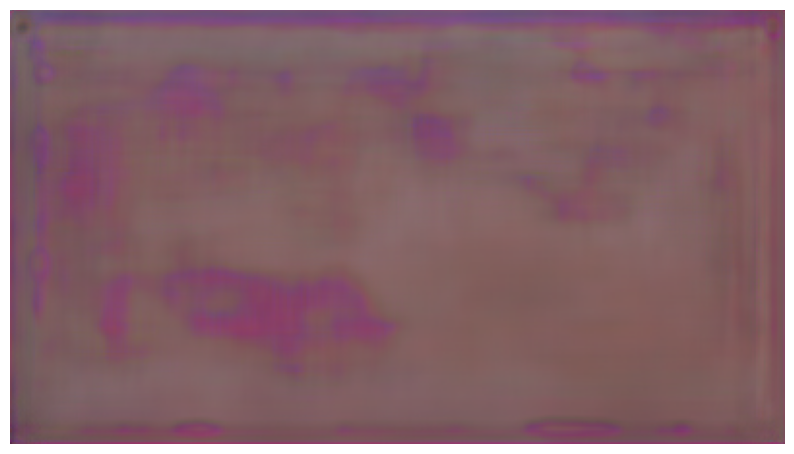

In [11]:
with torch.no_grad():
  print(Params().shape)
  img= norm_data(generator(Params()).cpu()) # 1 x 3 x 224 x 400 [225 x 400]
  print("img dimensions: ",img.shape)
  show_from_tensor(img[0])

## Create crops

In [12]:
## When we create an image with CLIP with give to CLIP various crops to help it create a better representation of the image
def create_crops(img, num_crops=32):
  p=size1//2
  img = torch.nn.functional.pad(img, (p,p,p,p), mode='constant', value=0) # 1 x 3 x 448 x 624 (adding 112*2 on all sides to 224x400)

  img = augTransform(img) #RandomHorizontalFlip and RandomAffine

  crop_set = []
  for ch in range(num_crops):
    gap1= int(torch.normal(1.2, .3, ()).clip(.43, 1.9) * size1)
    offsetx = torch.randint(0, int(size1*2-gap1),())
    offsety = torch.randint(0, int(size1*2-gap1),())

    crop=img[:,:,offsetx:offsetx+gap1, offsety:offsety+gap1]

    crop = torch.nn.functional.interpolate(crop,(224,224), mode='bilinear', align_corners=True)
    crop_set.append(crop)

  img_crops=torch.cat(crop_set,0) ## 30 x 3 x 224 x 224

  randnormal = torch.randn_like(img_crops, requires_grad=False)
  num_rands=0 # change this if you want more realistic images
  randstotal=torch.rand((img_crops.shape[0],1,1,1)).cuda() #32

  for ns in range(num_rands):
    randstotal*=torch.rand((img_crops.shape[0],1,1,1)).cuda()

  img_crops = img_crops + noise_factor*randstotal*randnormal

  return img_crops




## Show current state of generation

In [13]:
def show_generated_image(Params, show_crop):
  with torch.no_grad():
    generated = generator(Params())

    if (show_crop):
      print("Augmented cropped example")
      aug_gen = generated.float() # 1 x 3 x 224 x 400
      aug_gen = create_crops(aug_gen, num_crops=1)
      aug_gen_norm = norm_data(aug_gen[0])
      show_from_tensor(aug_gen_norm)

    print("Generation")
    latest_gen=norm_data(generated.cpu()) # 1 x 3 x 224 x 400
    show_from_tensor(latest_gen[0])

  return (latest_gen[0])

## Optimization process

#### Fill in the missing blanks

In [24]:
# optimize the loss value to drive the optimization
import torch.nn.functional as F
def optimize_result(Params, prompt):
  alpha=1 ## the importance of the include encodings
  beta=.5 ## the importance of the exclude encodings

  # image encoding

  ## To calculate the loss, we need to compare the encodings of the text prompts with the encodings of the image crops generated from the
  ## current state of our latent space parameters.
  ## So, first we need to pass the parameters through the generator to generate an image that we can use to encode

  # first, generate an image with the Generator
  out = generator(Params())
  # normalize the output
  out = norm_data(out)
  # create the crops
  out = create_crops(out)
  # normalize the crops
  out = normalize(out) # 30 x 3 x 224 x 224: 30 crops x 3 channels x image size that CLIP is expecting
  # get image embedding with CLIP
  image_enc= clipmodel.encode_image(out)## 30 x 512: For each of the 30 crops, CLIP will return an encoding with dimensionality 512
  image_enc = image_enc / image_enc.norm(dim=-1, keepdim=True)

  # Text encoding  w1 and w2 weights of the include and extra texts encodings
  final_enc = w1*prompt + w2*extras_enc # prompt dim: 1 x 512; extras_enc dim: 1 x 512
  ## normalize the text prompt
  final_text_include_enc = final_enc / final_enc.norm(dim=-1, keepdim=True) # 1 x 512
  final_text_exclude_enc = exclude_enc

  # Calculate the loss (cosine)

  ## 1. compare each of the 30 image crops with the final include text prompt
  main_loss = F.cosine_similarity(image_enc, final_text_include_enc)  # (30,)
     # output: 30, one value per image crop
  ## compare each of the 30 image crops with the exclude text prompt
  penalize_loss = F.cosine_similarity(image_enc, final_text_exclude_enc) # 30

  final_loss = -alpha*main_loss + beta*penalize_loss

  return final_loss

# standard optimizer
def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss


## Training loop

In [25]:
def training_loop(Params, optimizer, show_crop=False):
  res_img=[] # image results
  res_z=[] # latent space results

  for prompt in include_enc:
    iteration=0
    Params, optimizer = init_params() # 1 x 256 x 14 x 25 (225/16, 400/16)

    for it in range(total_iter):
      loss = optimize(Params, optimizer, prompt)

      if iteration>=80 and iteration%show_step == 0:
        new_img = show_generated_image(Params, show_crop)
        res_img.append(new_img)
        res_z.append(Params()) # 1 x 256 x 14 x 25
        print("loss:", loss.item(), "\niteration:",iteration)

      iteration+=1
    torch.cuda.empty_cache()
  return res_img, res_z


## Run training

Augmented cropped example


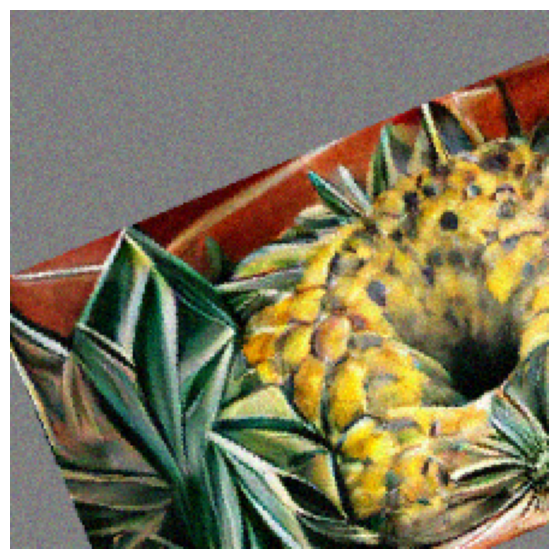

Generation


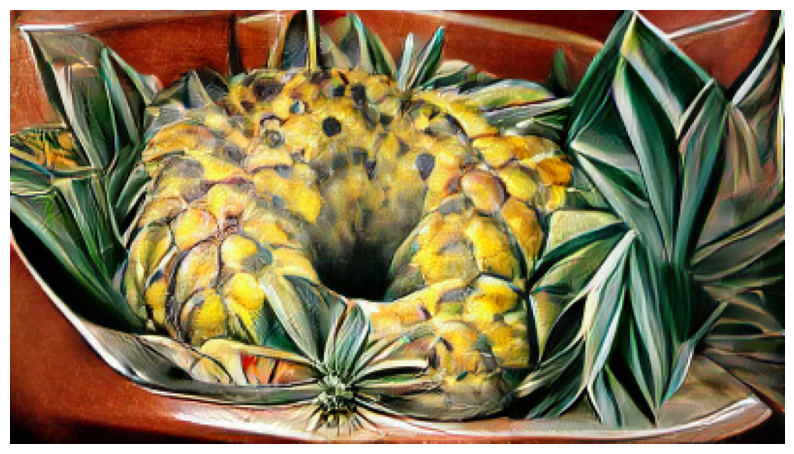

loss: -0.25537109375 
iteration: 80
Augmented cropped example


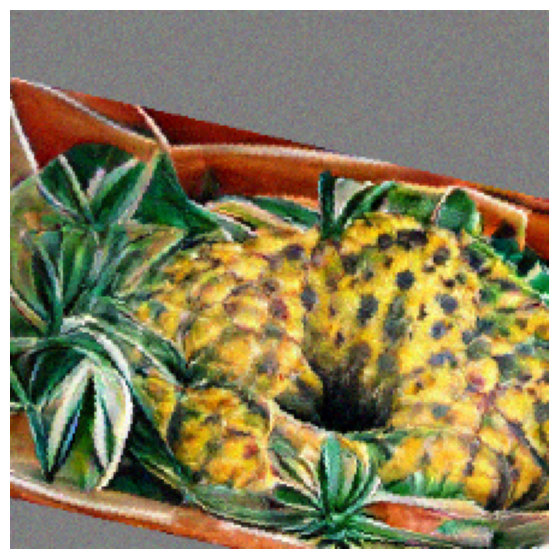

Generation


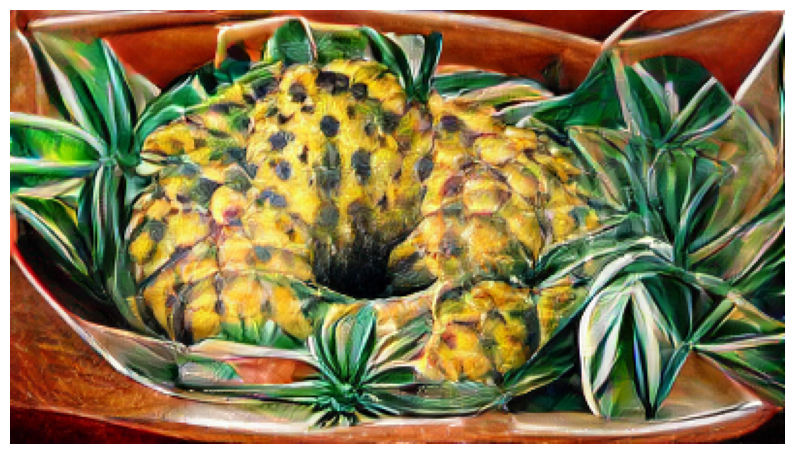

loss: -0.239013671875 
iteration: 90
Augmented cropped example


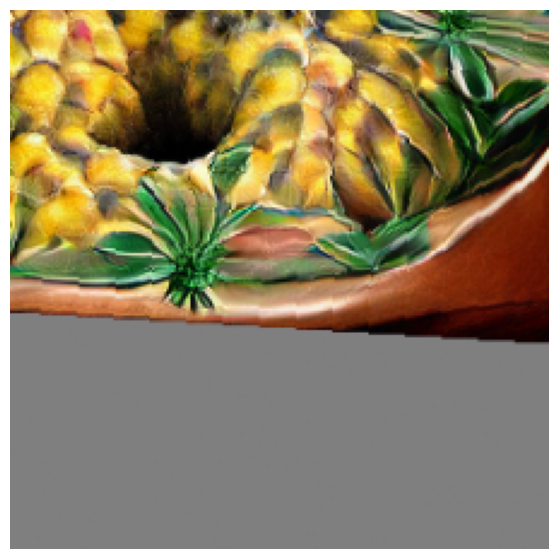

Generation


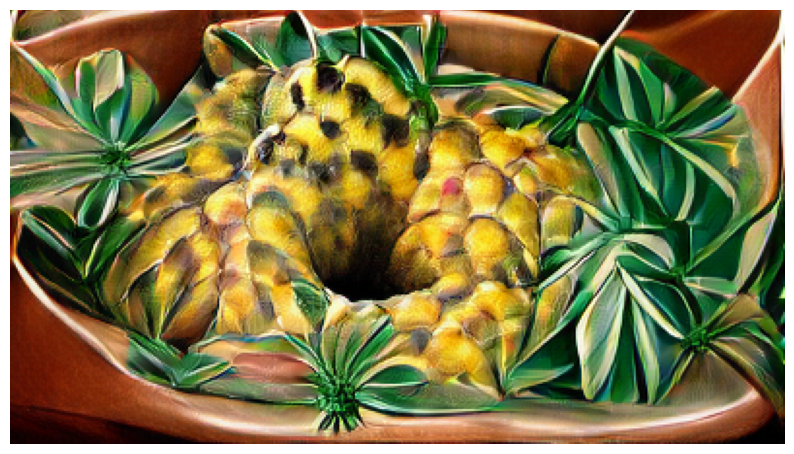

loss: -0.308349609375 
iteration: 100


In [26]:
torch.cuda.empty_cache()
#include=['sketch of a lady', 'sketch of a man on a horse']
include=['A painting of a pineapple in a bowl']
exclude='watermark'
extras = "" #watercolor paper texture
w1=1
w2=1
noise_factor= .22
total_iter=110
show_step=10 # set this to see the result every 10 interations beyond iteration 80
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=True)


## Study dimentionality of results

In [27]:
print(len(res_img), len(res_z))
print(res_img[0].shape, res_z[0].shape)
print(res_z[0].max(), res_z[0].min())

3 3
torch.Size([3, 224, 400]) torch.Size([1, 256, 14, 25])
tensor(5.7392, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-6.2530, device='cuda:0', grad_fn=<MinBackward1>)


## Another example

Generation


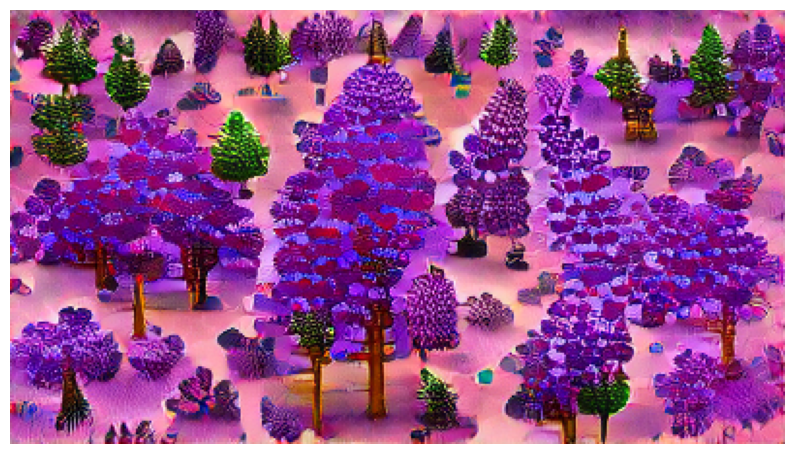

loss: -0.23095703125 
iteration: 109
Generation


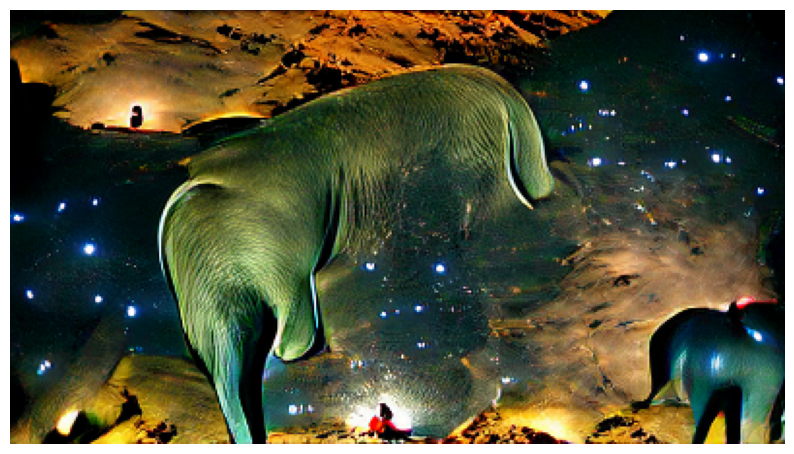

loss: -0.2325439453125 
iteration: 109
Generation


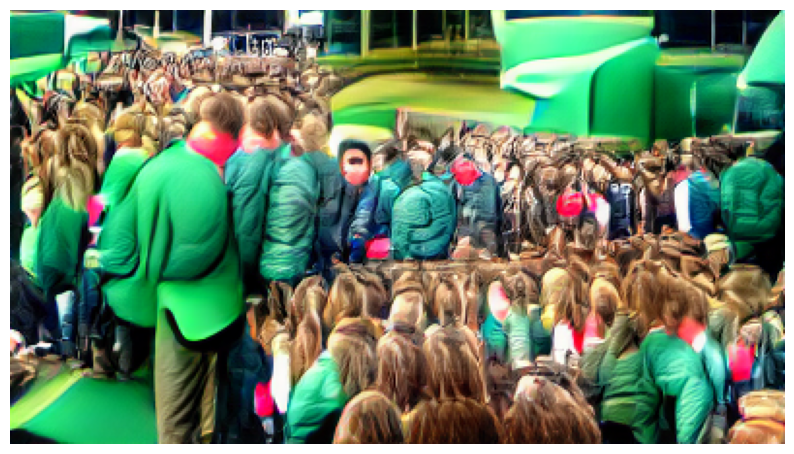

loss: -0.234130859375 
iteration: 109


In [28]:
torch.cuda.empty_cache()
include=['A forest with purple trees', 'an elephant at the top of a mountain, looking at the stars','one hundred people with green jackets']
exclude='watermark, cropped, confusing, incoherent, cut, blurry'
extras = ""
w1=1
w2=1
noise_factor= .22
total_iter=110
show_step=total_iter-1 # set this if you want to interpolate between only the final versions
include_enc, exclude_enc, extras_enc = createEncodings(include, exclude, extras)
res_img, res_z=training_loop(Params, optimizer, show_crop=False)


## Create video with interpolation

In [29]:
def interpolate(res_z_list, duration_list):
  gen_img_list=[]
  fps = 25

  for idx, (z, duration) in enumerate(zip(res_z_list, duration_list)):
    num_steps = int(duration*fps)
    z1=z
    z2=res_z_list[(idx+1)%len(res_z_list)] # 1 x 256 x 14 x 25 (225/16, 400/16)

    for step in range(num_steps):
      alpha = math.sin(1.5*step/num_steps)**6
      z_new = alpha * z2 + (1-alpha) * z1

      new_gen=norm_data(generator(z_new).cpu())[0] ## 3 x 224 x 400
      new_img=T.ToPILImage(mode='RGB')(new_gen)
      gen_img_list.append(new_img)

  return gen_img_list

durations=[5,5,5,5,5,5]
interp_result_img_list = interpolate(res_z, durations)

In [22]:
## create the video
out_video_path=f"../video.mp4"
writer = imageio.get_writer(out_video_path, fps=25)
for pil_img in interp_result_img_list:
  img = np.array(pil_img, dtype=np.uint8)
  writer.append_data(img)

writer.close()

In [23]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open('../video.mp4','rb').read()
data="data:video/mp4;base64,"+b64encode(mp4).decode()
HTML("""<video width=800 controls><source src="%s" type="video/mp4"></video>""" % data)